# Counting coins - "easy" case 
<b>1)</b> Upload image(s) to process

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving coins10.jpg to coins10.jpg


**2)** Open all images and convert them to HSV

<i>split</i> is used to separate each of the colour <b>channels</b> (which are stored into a single matrix <i>hsv</i> of size 3xHdimxVdim after cvtColor) to three separate matrices. It produces an array of 3 matrices (each one of size Hdim x Vdim), stored into img_HSV[i].
    <ul><li>imgHSV[i][0] is a matrix containing the 1st channel (Hue)</li>
        <li>imgHSV[i][1] is a matrix containing the 2nd channel (Sat)</li>
        <li>imgHSV[i][2] is a matrix containing the 3rd channel (Value)</li></ul>
Each channel is displayed in a subplot using Pyplot. Notice that the range for Hue values is set to 0-180 (so 180 is displayed as white). <b>Hue value is meaningless </b> when Saturation value is very low

**3)** Threshold Value to get objects as foreground (hopefully coins) in binary image<p>
Choose a Value threshold level that works across all images (60 recommended)<br>
Choose a size for the clean-up structuring element (10 recommended)

In [ ]:
#To HSV
import cv2          #imports computer vision library, matplot lib for plotting/showing graphs, numpy for mathematical functionalities
import numpy as np
import matplotlib


img_HSV=[] #array (list) of HSV images
filename=[] #array (list) of file names
i=0
for fn in uploaded.keys(): #for each filename, applies to each uploaded
  filename.append(fn) #append to filenames array, allows for adding to current set
  #open the uploaded image file and convert from BGR to HSV
  hsv = cv2.cvtColor(cv2.imread(filename[i]), cv2.COLOR_BGR2HSV)    # converison BGR to HSV
  #hsv is single image with 3 channels (H, S, V)
  img_HSV.append(cv2.split(hsv))  #split to array of 3 images, add to HSV array, segregation for manipulation
  i = i + 1
print('Converted '+str( len(img_HSV) )+' images')     
Vdim = hsv.shape[0] #rows
Hdim = hsv.shape[1] #cols
print('Hdim: ' + str(Hdim) + '; Vdim: ' + str(Vdim))


Converted 1 images
Hdim: 1600; Vdim: 1600


In [ ]:

from google.colab.patches import cv2_imshow     

img1 = cv2.imread(cv2.samples.findFile(filename[0]), cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)  # convert from BGR to Gray (1)
gray = cv2.medianBlur(gray,15)                 # applies median blur to previous stage (2)
gray = cv2.GaussianBlur(gray,(21,21),cv2.BORDER_DEFAULT)  # applies gaussian blur to previous stage (3)
    
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 0.9, 120,param1=50, param2=30, minRadius=30, maxRadius =110) #HoughCircles function
#circle_rounded = np.uint16(np.around(circles)) # gets x and y value for center and radius
  



**4)** <b>Function returning the coin value</b><p>
Classifies the coin type (hard-coded). Returns its value (-1 if unknown)<p>
This is the hard part: decide the type of coin using size and Saturation levels (at the central region and/or side regions)

In [ ]:
#input: ROI coords (top left, width, height), blob area, image number
#output: coin value (-1 if unknown), mean Sat at centre, mean sat on sides
#accesses Saturation image as well
def classify(x,y,w,h,img1):
  size = (w+h)/2
  im = img1
  sub_img = im[y+h//3:y+2*h//3, x+w//3:x+2*w//3]
  mcenter = cv2.mean(sub_img)
  meanSatcenter = mcenter[0]
  #check mean Saturation in 4 side regions
  sub_img = im[y+h//3:y+2*h//3, x+5:x+w//5] #left
  mside = cv2.mean(sub_img)
  meanSatside = mside[0]
  sub_img = im[y+4*h//5:y+h-5, x+w//3:x+2*w//3] #down
  mside = cv2.mean(sub_img)
  meanSatside = meanSatside + mside[0]
  sub_img = im[y+h//3:y+2*h//3, x+4*w//5:x+w-5] #right
  mside = cv2.mean(sub_img)
  meanSatside = meanSatside + mside[0]
  sub_img = im[y+5:y+h//5, x+w//3:x+2*w//3] #top
  mside = cv2.mean(sub_img)
  meanSatside = meanSatside + mside[0]
  meanSatside = meanSatside // 4
  if size <40 or size > 160:    #too small or too big
    return(-1,0,0)
  if size < 98:                                                                         # 5p coin
    return(0.05,meanSatcenter,meanSatside)
  elif meanSatcenter <48 and meanSatside <40:
    print("This is a washer!" +str(meanSatcenter))                                      # Washer
    return(-1,0,0)
  elif meanSatcenter > 60 and size > 100 and size <120 and meanSatside > 70 and ((meanSatside - meanSatcenter) >3): # 20p coin
      return (0.20, meanSatcenter ,meanSatside)
  elif meanSatcenter > 60 and meanSatcenter <180 and size >140 and meanSatside >120:    # 50p coin
      return(0.50,meanSatcenter,meanSatside)
  elif meanSatcenter > 60 and size > 140 and meanSatside:                               # £2 coin
    return(2.00,meanSatcenter,meanSatside)
  elif meanSatcenter > 60 and meanSatside > 60 and size < 110:                          # 1p coin
    return(0.01,meanSatcenter,meanSatside)
  elif meanSatcenter > 100 and meanSatside > 100 and (meanSatside - meanSatcenter < 30) and size < 130:   # £1 coin
    return(1.00,meanSatcenter,meanSatside)
  elif size < 138 and size > 126 and meanSatcenter > 60 and meanSatcenter < 100 and meanSatside >100 and ((meanSatside - meanSatcenter )> 3):   # 10p coin
    return(0.10,meanSatcenter,meanSatside)
  elif size > 100 and meanSatside < 100 and meanSatcenter < 110:                        # 2p coin
    return(0.02,meanSatcenter,meanSatside)

  return(-1,0,0)

**5)** Labelling and individual regions analysis<br>
This piece of code processes one image from the array of binary images (the one selected with "image to use")<br>
It extracts the blobs using <i>connectedComponentsWithStats()</i>, then uses the coin classification function to calculate its value. Adds the total coins value<br>
Displays the processing results and writes the results to a text file (comma separated values format)

Unknown value!
Unknown value!
Value=1.0
Sat=169.0
Pos=637 335


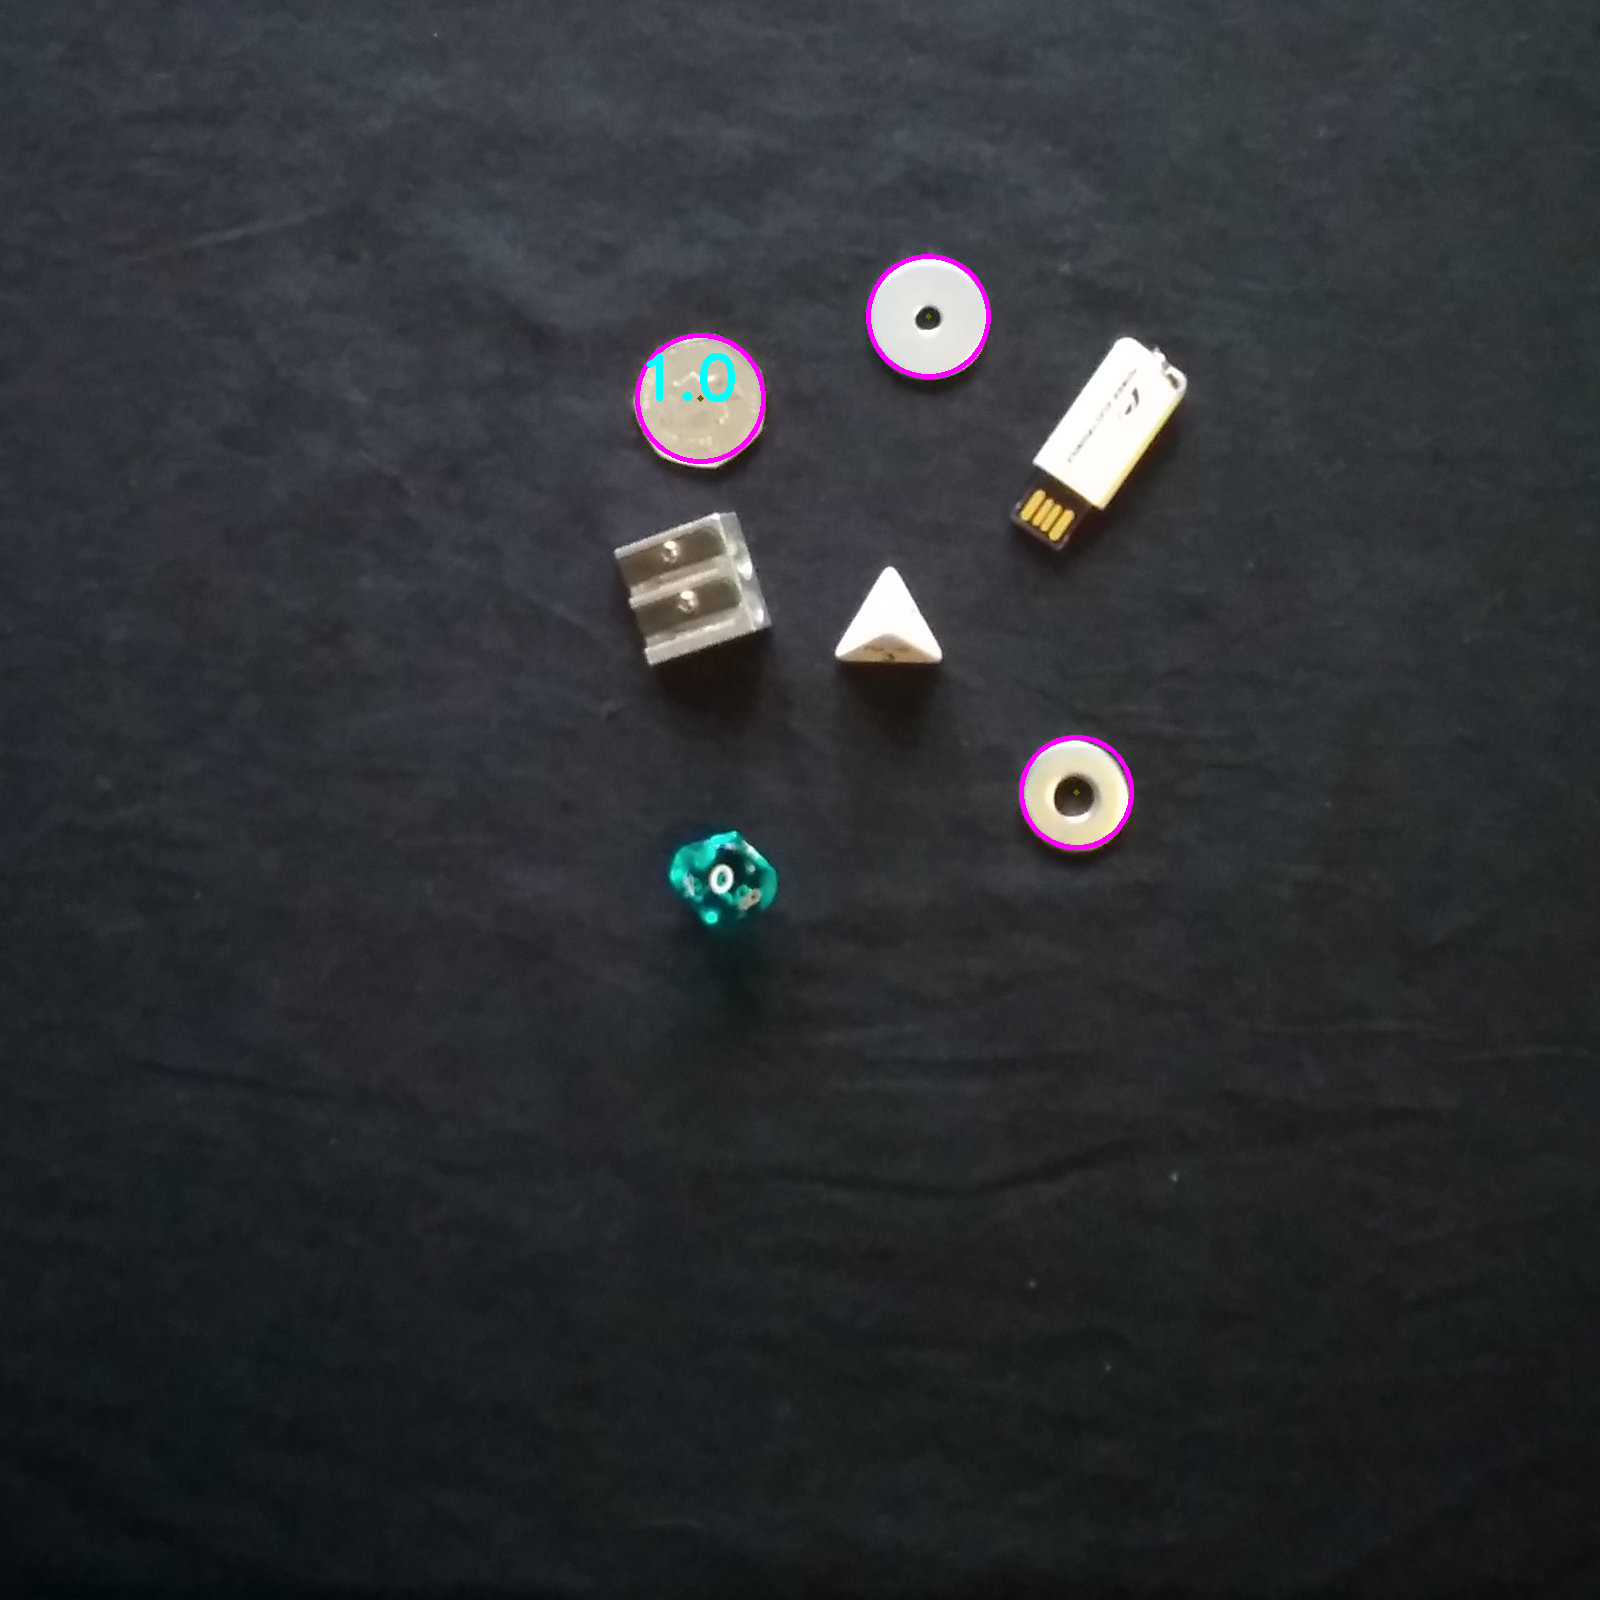

TOTAL: £1.0


In [ ]:
image_to_use = 0 #Processing only one this image element so far
fname = 'result_'+filename[image_to_use]+'.csv'
fp = open(fname, 'w')
fp.write(' x1, y1,w,h,SatCent,SatSides,Value\n')
TotalValue = 0
#get RGB again to clean up drawings if repeated execution
#get binary image to process for blob extraction
#use connectedComponentsWithStats to retrieve blobs and stats
if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:                   #for each in circles, produce:
            radius = i[2]                         # radius
            x = i[0]-radius                       # X coordinate
            y = i[1]-radius                       # Y coordinate
            w = 2*radius                          # Diameter 1
            h = 2*radius                          # Diameter 2
            center = (i[0], i[1])                 # center using x,y
            # circle center
            cv2.circle(img1, center, 1, (0, 100, 100), 3)
            # circle outline
            cv2.circle(img1, center, radius, (255, 0, 255), 3)
            (value, SatC, SatSide)  = classify(x,y,w,h,img1)        #classify function definition for circle
            if value == -1 :
              print('Unknown value!')
            else :
              cv2.putText(img1, str(value), (int(x),int(y+h/2)), cv2.FONT_ITALIC, 2, (255,255,0),6)    # labels in specific font
              print('Value=' + str(value))    # prints value
              print('Sat=' + str(SatC))       # prints saturation center
              print('Pos=' + str(x) , str(y)) # prints position
              TotalValue = TotalValue + value
              # saves result to a text file
              fp.write(str(x)+','+str(y)+','+str(w)+','+str(h)+','+str(int(SatC))+','+str(int(SatSide))+','+str(value)+'\n')
   
fp.close()
# plots the result
cv2_imshow(img1)
print('TOTAL: £' +str(TotalValue))

In [ ]:
stats #displays the stats from all blobs

NameError: ignored